# Intro to Distributional Reinforcement Learning

## The Limitation of Expectations

Traditional reinforcement learning algorithms operate on expected values, representing each state-action pair with a single number. This simplification, while computationally convenient, discards crucial information about the underlying reward structure. The traditional Q-learning framework treats different reward distributions as identical if they share the same expected value, leading to:

1. Risk-Insensitive Decision Making
2. Poor Performance in Multimodal Reward Distributions
3. Slower Learning in Environments with Reward Variability

## Beyond Expectations: A Distributional Perspective

Rather than reducing a state-action pair to a single expected value, a distributional approach maintains the full spectrum of possible outcomes. The categorical DQN (C51) algorithm discretizes this distribution into a fixed set of atoms, enabling the network to learn uncertainty explicitly.

This distributional representation captures critical information about:
- Reward Variance
- Risk Profiles
- Multimodality in Returns

The following implementation demonstrates how C51 learns and utilizes these complete return distributions, providing a more robust framework for decision-making under uncertainty. The original paper can be found [here](https://arxiv.org/abs/1707.06887).


# Simulation Environment

In [8]:
# Game of Pong Simulation environment
import gymnasium as gym
import gymnasium.utils.seeding as seeding
from gymnasium.wrappers import AtariPreprocessing
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Hyperparameters
BUFFER_SIZE = int(1e5)    # replay buffer size
BATCH_SIZE = 64           # minibatch size
GAMMA = 0.99              # discount factor
TAU = 1e-3               # for soft update of target parameters
LR = 5e-4                # learning rate
UPDATE_EVERY = 4         # how often to update the network

# C51 specific parameters
N_ATOMS = 51             # number of atoms for distribution
V_MIN = -10             # minimum value of distribution support
V_MAX = 10              # maximum value of distribution support
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)  # support interval

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create the Pong environment
DefaultRandomSeed = 10
env = gym.make("ALE/Pong-v5", frameskip=1)
env.np_random, _ = seeding.np_random(DefaultRandomSeed)
env.reset(seed=DefaultRandomSeed)
env = AtariPreprocessing(env)  # Frame skipping, Grayscale, Resize (To 84*84)

A.L.E: Arcade Learning Environment (version 0.10.1+unknown)
[Powered by Stella]
Game console created:
  ROM file:  /opt/anaconda3/envs/DRL101/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is 932445052
Game console created:
  ROM file:  /opt/anaconda3/envs/DRL101/lib/python3.11/site-packages/ale_py/roms/pong.bin
  Cart Name: Video Olympics (1978) (Atari)
  Cart MD5:  60e0ea3cbe0913d39803477945e9e5ec
  Display Format:  AUTO-DETECT ==> NTSC
  ROM Size:        2048
  Bankswitch Type: AUTO-DETECT ==> 2K

Running ROM file...
Random seed is -1705377069


# Mathematical Framework: From DQN to Distributional RL

## DQN Foundations Review
The Bellman equation forms the basis of DQN:

$Q(s,a) = \mathbb{E}[R(s,a) + \gamma \max_{a'} Q(s',a')]$

The optimization objective minimizes:

$\mathcal{L}(\theta) = \mathbb{E}[(r + \gamma \max_{a'} Q(s',a';\theta^-) - Q(s,a;\theta))^2]$

where:
- $\theta$ represents the online network parameters
- $\theta^-$ represents the target network parameters

## The Distributional Extension
C51 extends this to full distributions:

$Z(s,a) \stackrel{D}{=} R(s,a) + \gamma Z(s',\arg\max_{a'}\mathbb{E}[Z(s',a')])$

where $Z$ and $R$ are random variables representing the return and reward distributions, respectively.

The distribution is parameterized using N atoms:

$z_i = V_{MIN} + i\Delta z$ for $i \in \{0,...,N-1\}$
$\Delta z = \frac{V_{MAX} - V_{MIN}}{N-1}$

The probability mass function is defined as:

$P_\theta(s,a) = \{\mathbf{p}_i(s,a) = \frac{e^{\theta_i(s,a)}}{\sum_j e^{\theta_j(s,a)}}\}_{i=0}^{N-1}$

The optimization objective becomes:

$\mathcal{L}(\theta) = D_{KL}(\Phi \hat{Z}_{\theta^-} || Z_\theta)$

where:
- $\Phi$ is the categorical projection operator
- $D_{KL}$ is the Kullback-Leibler divergence
- $\hat{Z}_{\theta^-}$ is the target network distribution
- $Z_\theta$ is the online network distribution

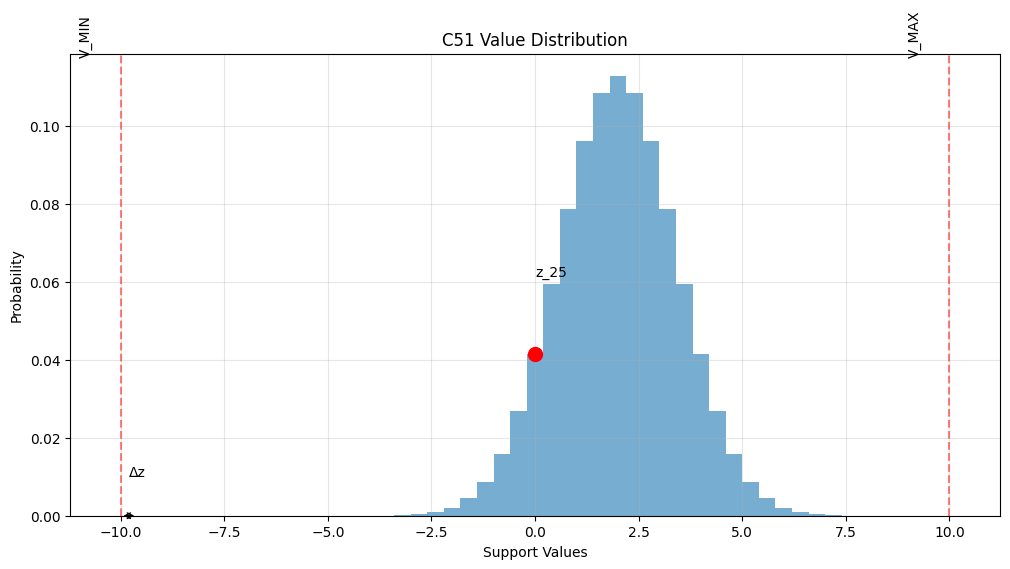

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_c51_distribution():
   # C51 parameters
   N_ATOMS = 51
   V_MIN = -10
   V_MAX = 10
   DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)
   
   # Create support points
   z_i = np.linspace(V_MIN, V_MAX, N_ATOMS)
   
   # Create a sample distribution (gaussian for illustration)
   probs = F.softmax(torch.tensor([-((x - 2)**2)/4 for x in z_i]), dim=0).numpy()
   
   plt.figure(figsize=(12, 6))
   
   # Plot probability mass at each atom
   plt.bar(z_i, probs, width=DELTA_Z, alpha=0.6, label='Probability Mass')
   
   # Mark important parameters
   plt.axvline(x=V_MIN, color='r', linestyle='--', alpha=0.5)
   plt.axvline(x=V_MAX, color='r', linestyle='--', alpha=0.5)
   
   # Annotate key points
   plt.text(V_MIN-1, plt.ylim()[1], 'V_MIN', rotation=90)
   plt.text(V_MAX-1, plt.ylim()[1], 'V_MAX', rotation=90)
   
   # Mark Δz
   plt.annotate('', xy=(z_i[0], 0), xytext=(z_i[1], 0),
               arrowprops=dict(arrowstyle='<->'))
   plt.text(z_i[0] + DELTA_Z/2, 0.01, 'Δz')
   
   # Mark a specific z_i
   i = 25  # middle atom
   plt.scatter([z_i[i]], [probs[i]], color='red', s=100, zorder=3)
   plt.annotate(f'z_{i}', xy=(z_i[i], probs[i]), xytext=(z_i[i], probs[i]+0.02))
   
   plt.title('C51 Value Distribution')
   plt.xlabel('Support Values')
   plt.ylabel('Probability')
   plt.grid(True, alpha=0.3)
   plt.show()

visualize_c51_distribution()

NameError: name 'state_dim' is not defined